In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, \
    GlobalAveragePooling1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv(
    'UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt',
    header=None,
    delim_whitespace=True,
)

In [2]:
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # since there are 9 files
K = 6 # number of classes (1-6)

In [5]:
def load_data():
    # Returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))

    # train load_data
    ts_filenames = [
        'body_acc_x_train.txt','body_acc_y_train.txt','body_acc_z_train.txt',
        'body_gyro_x_train.txt','body_gyro_y_train.txt','body_gyro_z_train.txt',
        'total_acc_x_train.txt','total_acc_y_train.txt','total_acc_z_train.txt'
    ]

    ts_file_prefix = 'UCI HAR Dataset/train/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header=None,
            delim_whitespace=True
        )

        # Ntrain x T array
        x = df.to_numpy()
        Xtrain[:,:,d] = x

    # train labels
    Ytrain = pd.read_csv(
        f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
    Ytrain = Ytrain.flatten()

    # test load_data
    ts_filenames = [
        'body_acc_x_test.txt','body_acc_y_test.txt','body_acc_z_test.txt',
        'body_gyro_x_test.txt','body_gyro_y_test.txt','body_gyro_z_test.txt',
        'total_acc_x_test.txt','total_acc_y_test.txt','total_acc_z_test.txt'
    ]

    ts_file_prefix = 'UCI HAR Dataset/test/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial Signals/{fn}',
            header=None,
            delim_whitespace=True
        )

        # Ntrain x T array
        x = df.to_numpy()
        Xtest[:,:,d] = x

    # test labels
    Ytest = pd.read_csv(
        f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
    Ytest = Ytest.flatten()

    return Xtrain, Ytrain, Xtest, Ytest

In [6]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

In [7]:
# CNN

i = Input(shape=(T,D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 32)           1472      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 41, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 128)           24704     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)              

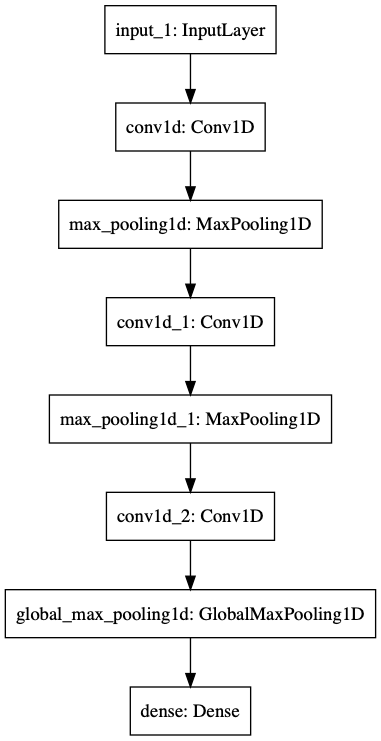

In [11]:
tf.keras.utils.plot_model(model)

In [12]:
check_point = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True
)

In [13]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=15,
    callbacks=[check_point],
    validation_data=(Xtest, Ytest)
)

Epoch 1/15
230/230 [==============================] - 2s 7ms/step - loss: 0.4145 - accuracy: 0.8679 - val_loss: 0.2629 - val_accuracy: 0.9091
Epoch 2/15
230/230 [==============================] - 1s 6ms/step - loss: 0.1256 - accuracy: 0.9495 - val_loss: 0.2434 - val_accuracy: 0.9097
Epoch 3/15
230/230 [==============================] - 1s 6ms/step - loss: 0.1113 - accuracy: 0.9543 - val_loss: 0.2438 - val_accuracy: 0.9125
Epoch 4/15
230/230 [==============================] - 1s 5ms/step - loss: 0.1049 - accuracy: 0.9558 - val_loss: 0.2444 - val_accuracy: 0.9097
Epoch 5/15
230/230 [==============================] - 1s 6ms/step - loss: 0.1023 - accuracy: 0.9558 - val_loss: 0.2457 - val_accuracy: 0.9091
Epoch 6/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0898 - accuracy: 0.9610 - val_loss: 0.4081 - val_accuracy: 0.8799
Epoch 7/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0880 - accuracy: 0.9614 - val_loss: 0.2621 - val_accuracy: 0.9013
Epoch 

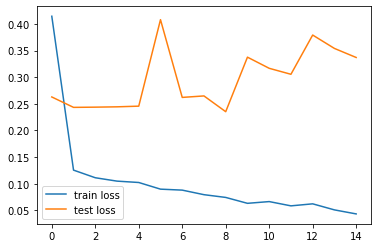

In [15]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

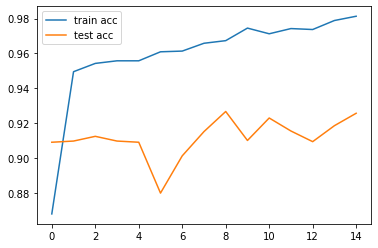

In [16]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [17]:
# load best model
best_model = tf.keras.models.load_model('best_model.h5')

In [19]:
# make predictions
Ptest = best_model.predict(Xtest)

In [20]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9267051238547676

In [21]:
from sklearn.preprocessing import StandardScaler

def load_features():
    # Returns:
    # X_train (Ntrain x D)
    # X test (Xtest x D)

    # train data
    df = pd.read_csv(
        'UCI HAR Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True
    )

    feat_train = df.to_numpy()

    # test data
    df = pd.read_csv(
        'UCI HAR Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True
    )

    feat_test = df.to_numpy()

    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.fit_transform(feat_test)

    return feat_train, feat_test

In [22]:
feat_train, feat_test = load_features()

In [23]:
D_feat = feat_train.shape[1]

In [27]:
# Combined Model

# CNN
i = Input(shape=(T,D))
x = Conv1D(32, 5, activation='relu')(i)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

# ANN
i2 = Input(shape=(D_feat,))
x2 = Dense(64, activation='relu')(i2)

x = Concatenate()([x, x2])
x = Dense(K)(x)
model = Model([i, i2], x)

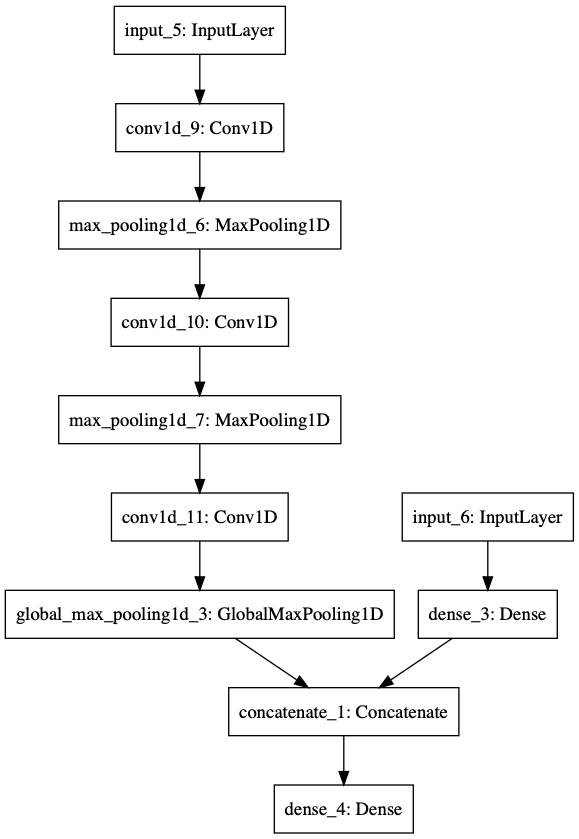

In [28]:
tf.keras.utils.plot_model(model)

In [29]:
check_point3 = ModelCheckpoint(
    'best_model_combined.h5',monitor='val_accuracy', save_best_only=True
)

In [30]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [31]:
r = model.fit(
    [Xtrain, feat_train],
    Ytrain,
    epochs=15,
    callbacks=[check_point3],
    validation_data=([Xtest, feat_test], Ytest)
)

Epoch 1/15
230/230 [==============================] - 2s 7ms/step - loss: 0.2308 - accuracy: 0.9134 - val_loss: 0.1815 - val_accuracy: 0.9311
Epoch 2/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0730 - accuracy: 0.9712 - val_loss: 0.1507 - val_accuracy: 0.9433
Epoch 3/15
230/230 [==============================] - 2s 7ms/step - loss: 0.0566 - accuracy: 0.9786 - val_loss: 0.1734 - val_accuracy: 0.9362
Epoch 4/15
230/230 [==============================] - 1s 6ms/step - loss: 0.0509 - accuracy: 0.9800 - val_loss: 0.1883 - val_accuracy: 0.9420
Epoch 5/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0408 - accuracy: 0.9848 - val_loss: 0.1458 - val_accuracy: 0.9525
Epoch 6/15
230/230 [==============================] - 1s 6ms/step - loss: 0.0347 - accuracy: 0.9864 - val_loss: 0.1567 - val_accuracy: 0.9471
Epoch 7/15
230/230 [==============================] - 1s 5ms/step - loss: 0.0322 - accuracy: 0.9876 - val_loss: 0.1446 - val_accuracy: 0.9549
Epoch 

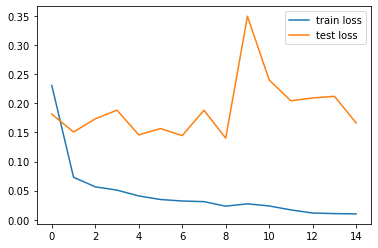

In [32]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

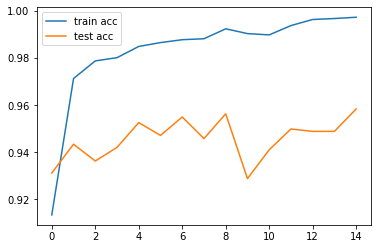

In [33]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [34]:
# load best model
best_model = tf.keras.models.load_model('best_model_combined.h5')

In [35]:
# make predictions
Ptest = best_model.predict([Xtest, feat_test])

In [36]:
# evaluate
np.mean(np.argmax(Ptest, axis=1) == Ytest)

0.9582626399728538